# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [2]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [260]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [261]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [262]:
df = df.rename(columns={'ipn31152n':'amount'})

In [263]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [264]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


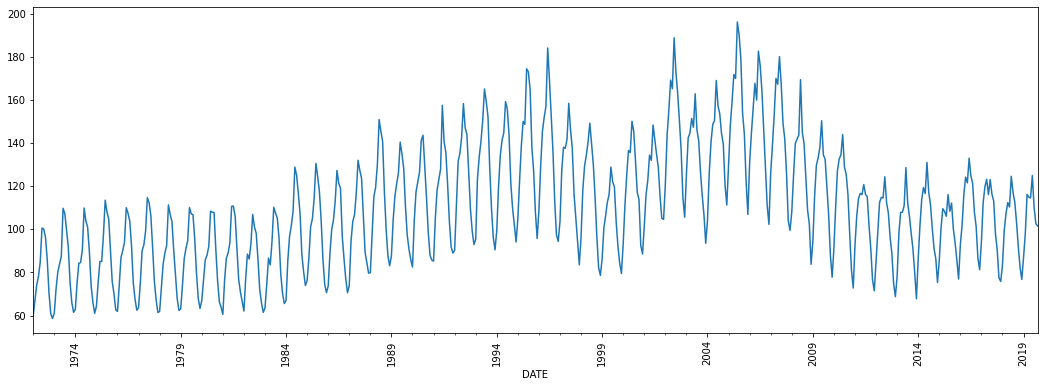

In [265]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

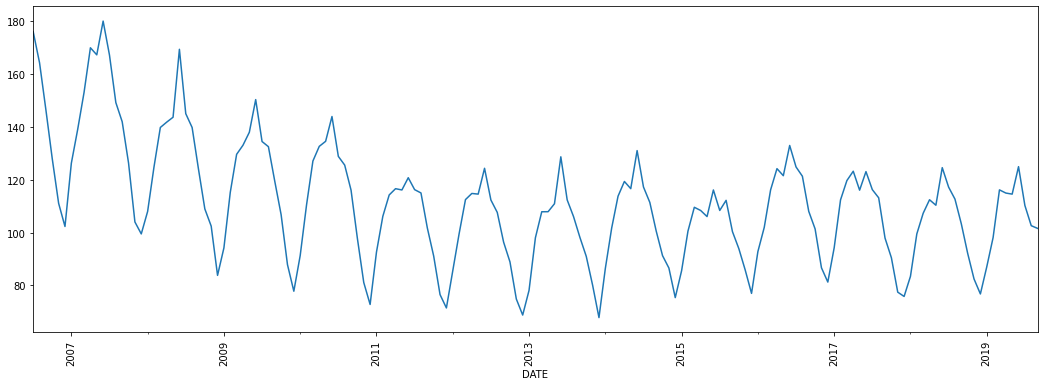

In [266]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### 3. Check missing values

In [267]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

### 5. Preprocessing of Data

### Train Test Split

In [268]:
len(df)

573

In [269]:
len(df)- 18

555

In [270]:
test_size = 18

In [271]:
test_ind = len(df)- test_size

In [272]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [234]:
train

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558
2010-06-01,143.952
2010-07-01,128.857
2010-08-01,125.556
2010-09-01,116.069


In [273]:
test

,amount
DATE,
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584
2018-07-01,117.222
2018-08-01,112.678
2018-09-01,103.312
2018-10-01,92.132
2018-11-01,82.435
2018-12-01,76.761


# Scaling

In [274]:
from sklearn.preprocessing import StandardScaler

In [275]:
scaler = StandardScaler()

In [276]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [277]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
# help(TimeseriesGenerator)

In [278]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [279]:
generator[0]

(array([[[-1.77172405],
         [-1.52055234],
         [-1.26668432],
         [-1.12949757],
         [-0.89413223],
         [-0.33390641],
         [-0.35052664],
         [-0.48377153],
         [-0.85743469],
         [-1.40261845],
         [-1.74182392],
         [-1.81780917]]]),
 array([[-1.73147741]]))

In [280]:
train_scaled

array([[-1.77172405e+00],
       [-1.52055234e+00],
       [-1.26668432e+00],
       [-1.12949757e+00],
       [-8.94132234e-01],
       [-3.33906412e-01],
       [-3.50526638e-01],
       [-4.83771525e-01],
       [-8.57434689e-01],
       [-1.40261845e+00],
       [-1.74182392e+00],
       [-1.81780917e+00],
       [-1.73147741e+00],
       [-1.33847294e+00],
       [-1.05920926e+00],
       [-9.24481750e-01],
       [-8.01862909e-01],
       [-1.01110034e-02],
       [-9.40401377e-02],
       [-3.66916863e-01],
       [-6.51265331e-01],
       [-1.22882615e+00],
       [-1.56040621e+00],
       [-1.71623366e+00],
       [-1.66495405e+00],
       [-1.22741784e+00],
       [-9.11658310e-01],
       [-9.00335184e-01],
       [-6.89753345e-01],
       [-4.59805632e-03],
       [-2.17338366e-01],
       [-3.18673269e-01],
       [-7.27377970e-01],
       [-1.28578501e+00],
       [-1.55251187e+00],
       [-1.73269111e+00],
       [-1.61943862e+00],
       [-1.22484536e+00],
       [-8.7

In [281]:
X, y = generator[0]

In [282]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.77172405 -1.52055234 -1.26668432 -1.12949757 -0.89413223 -0.33390641
 -0.35052664 -0.48377153 -0.85743469 -1.40261845 -1.74182392 -1.81780917]
Predict this y: 
 [[-1.73147741]]


## Modelling & Model Performance

### Creating Model

### with "tanh" activation function

In [283]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [284]:
n_features = 1

In [285]:
model = Sequential()
model.add(LSTM(120, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [286]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 120)               58560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [287]:
from tensorflow.keras.callbacks import EarlyStopping

In [288]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 6)

In [289]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [290]:
len(validation_generator)

6

In [291]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
543/543 [==============================] - 4s 5ms/step - loss: 0.3218 - val_loss: 0.0342
Epoch 2/64
543/543 [==============================] - 3s 5ms/step - loss: 0.0915 - val_loss: 0.0527
Epoch 3/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0845 - val_loss: 0.0361
Epoch 4/64
543/543 [==============================] - 2s 5ms/step - loss: 0.0850 - val_loss: 0.0614
Epoch 5/64
543/543 [==============================] - 3s 5ms/step - loss: 0.0812 - val_loss: 0.0444
Epoch 6/64
543/543 [==============================] - 3s 5ms/step - loss: 0.0889 - val_loss: 0.0601
Epoch 7/64
543/543 [==============================] - 2s 5ms/step - loss: 0.0804 - val_loss: 0.0615


<AxesSubplot:>

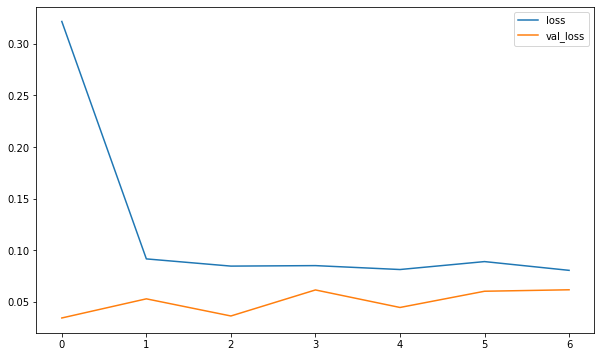

In [292]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [293]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [294]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [295]:
validation_generator[0]

(array([[[ 0.08486879],
         [ 0.01139232],
         [ 0.51490697],
         [ 0.25438307],
         [ 0.09360883],
         [-0.23780846],
         [-0.63339956],
         [-0.97653982],
         [-1.17730947],
         [-0.8150402 ],
         [-0.42181633],
         [ 0.21723968]]]),
 array([[0.17472488]]))

In [52]:
test_scaled

array([[-0.67885026],
       [-1.05352659],
       [-1.47405696],
       [-0.83657786],
       [-0.31090033],
       [ 0.10203626],
       [ 0.29325874],
       [ 0.1999222 ],
       [ 0.69390816],
       [ 0.22190814],
       [ 0.02120974],
       [-0.34907146],
       [-0.66982345],
       [-0.83058513],
       [-1.21446997],
       [-0.86471081],
       [-0.35110789],
       [-0.04184085],
       [-0.08357059],
       [-0.16255953],
       [ 0.18301706],
       [-0.08302549],
       [ 0.04819762],
       [-0.35829712],
       [-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0

In [296]:
y_pred = model.predict(validation_generator)

In [297]:
y_pred

array([[ 0.36901155],
       [ 0.47946724],
       [ 0.38834628],
       [ 0.34801537],
       [-0.10414489],
       [-0.5619719 ]], dtype=float32)

In [298]:
len(y_pred)

6

In [328]:
test_scaled[12:]

array([[ 0.17472488],
       [ 0.16025251],
       [ 0.5282258 ],
       [ 0.00816523],
       [-0.26269456],
       [-0.29885426]])

In [300]:
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.2272596199714294 
 mae: 0.2358163960684029 
 mse: 0.061513107745271495 
 rmse: 0.24801836170991753


In [301]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [302]:
train.shape

(555, 1)

In [303]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.7680431616457198 
 mae: 0.17675451753169868 
 mse: 0.05281370570164968 
 rmse: 0.22981232713161773


#### Inverse Transformations and Comparing

In [304]:
true_predictions = scaler.inverse_transform(test_predictions)

In [305]:
test

,amount
DATE,
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584
2018-07-01,117.222
2018-08-01,112.678
2018-09-01,103.312
2018-10-01,92.132
2018-11-01,82.435
2018-12-01,76.761


In [306]:
test['Predictions'] = true_predictions

In [64]:
test

,amount,Predictions
DATE,,
2013-10-01,90.998,86.954
2013-11-01,80.069,77.720
2013-12-01,67.803,75.110
2014-01-01,86.397,84.368
2014-02-01,101.731,99.786
2014-03-01,113.776,108.483
2014-04-01,119.353,113.255
2014-05-01,116.631,122.518
2014-06-01,131.040,129.923


<AxesSubplot:xlabel='DATE'>

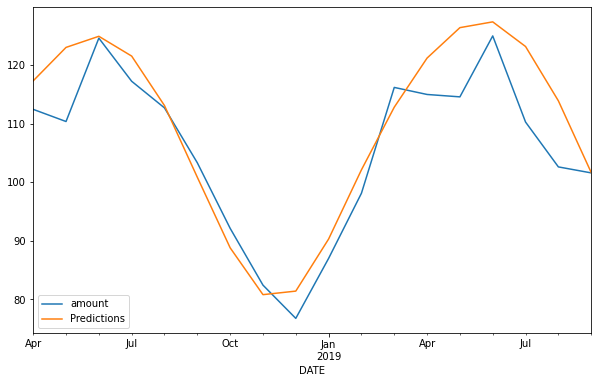

In [307]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [308]:
eval_metrics(test.amount, test.Predictions)

r2_score: 0.7680431050844249 
 mae: 4.995215148925782 
 mse: 42.18072204964068 
 rmse: 6.4946687405625765


### with "relu" activation function

In [329]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [330]:
n_features = 1

In [331]:
model = Sequential()
model.add(LSTM(120, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')

In [313]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 120)               58560     
_________________________________________________________________
dropout_11 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [332]:
from tensorflow.keras.callbacks import EarlyStopping

In [333]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8)

In [334]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [335]:
len(validation_generator)

6

In [336]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
543/543 [==============================] - 3s 5ms/step - loss: 0.4486 - val_loss: 0.0916
Epoch 2/64
543/543 [==============================] - 2s 4ms/step - loss: 0.1930 - val_loss: 0.0494
Epoch 3/64
543/543 [==============================] - 3s 5ms/step - loss: 0.1363 - val_loss: 0.0553
Epoch 4/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0999 - val_loss: 0.0585
Epoch 5/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0856 - val_loss: 0.0745
Epoch 6/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0813 - val_loss: 0.0856
Epoch 7/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0848 - val_loss: 0.0791
Epoch 8/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0864 - val_loss: 0.0774
Epoch 9/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0774 - val_loss: 0.1028
Epoch 10/64
543/543 [==============================] - 2s 4ms/step - loss: 0.0719 - val_loss: 0.0491

<AxesSubplot:>

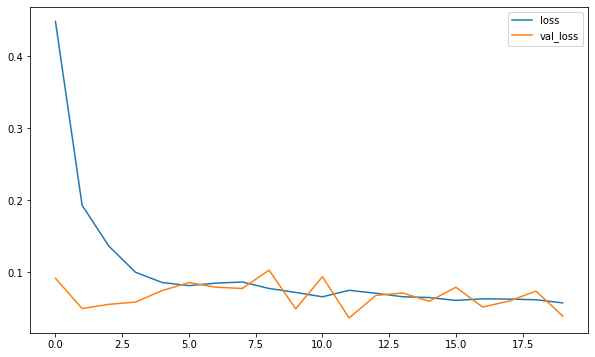

In [337]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [338]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [339]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [322]:
y_pred = model.predict(validation_generator)

In [340]:
y_pred

array([[ 0.41851336],
       [ 0.5374819 ],
       [ 0.57850266],
       [ 0.57373786],
       [ 0.09384318],
       [-0.39339072]], dtype=float32)

In [341]:
test_scaled[12:]

array([[ 0.17472488],
       [ 0.16025251],
       [ 0.5282258 ],
       [ 0.00816523],
       [-0.26269456],
       [-0.29885426]])

In [342]:
eval_metrics(test_scaled[12:], y_pred)

r2_score: -0.38224329318587014 
 mae: 0.281323594274346 
 mse: 0.11003188499192658 
 rmse: 0.331710543986661


In [344]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [345]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.5001983746145995 
 mae: 0.30340924676746844 
 mse: 0.1137986538340124 
 rmse: 0.337340560611991


#### Inverse Transformations and Comparing

In [346]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [347]:
test['Predictions_Relu'] = true_predictions_relu

In [348]:
test

,amount,Predictions,Predictions_Relu
DATE,,,
2018-04-01,112.431,117.296,107.525
2018-05-01,110.354,123.001,108.704
2018-06-01,124.584,124.897,114.452
2018-07-01,117.222,121.519,111.290
2018-08-01,112.678,113.072,103.957
2018-09-01,103.312,100.845,92.622
2018-10-01,92.132,88.807,80.434
2018-11-01,82.435,80.809,69.206
2018-12-01,76.761,81.414,67.196


<AxesSubplot:xlabel='DATE'>

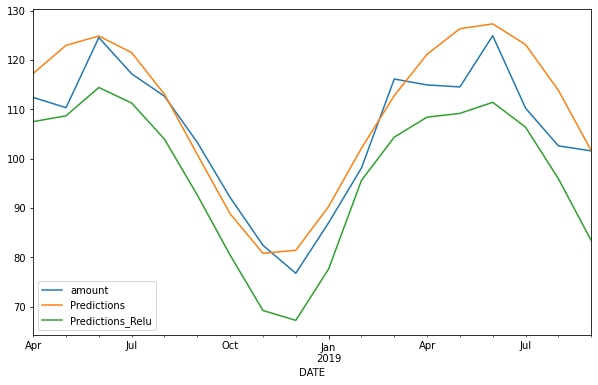

In [349]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [350]:
eval_metrics(test.amount, test.Predictions_Relu)

r2_score: 0.5001984615714049 
 mae: 8.574571371120875 
 mse: 90.88753227237561 
 rmse: 9.533495280975158


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [351]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [352]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [353]:
model = Sequential()
model.add(LSTM(120, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
555/555 [==============================] - 5s 6ms/step - loss: 0.2391
Epoch 2/64
555/555 [==============================] - 3s 6ms/step - loss: 0.0991
Epoch 3/64
555/555 [==============================] - 4s 6ms/step - loss: 0.0821
Epoch 4/64
555/555 [==============================] - 3s 6ms/step - loss: 0.0791
Epoch 5/64
555/555 [==============================] - 4s 6ms/step - loss: 0.0766
Epoch 6/64
555/555 [==============================] - 3s 6ms/step - loss: 0.0720
Epoch 7/64
555/555 [==============================] - 3s 6ms/step - loss: 0.0649
Epoch 8/64
555/555 [==============================] - 4s 6ms/step - loss: 0.0637
Epoch 9/64
555/555 [==============================] - 4s 6ms/step - loss: 0.0691
Epoch 10/64
555/555 [==============================] - 4s 7ms/step - loss: 0.0647
Epoch 11/64
555/555 [==============================] - 4s 6ms/step - loss: 0.0640
Epoch 12/64
555/555 [==============================] - 4s 7ms/step - loss: 0.0614
Epoch 13/64
555/555 [====

In [355]:
scaled_full_data.shape

(573, 1)

In [356]:
scaled_full_data[-length:].shape

(18, 1)

In [357]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [358]:
forecast = scaler.inverse_transform(forecast)

In [359]:
forecast

array([[ 90.46467 ],
       [ 81.265686],
       [ 81.90872 ],
       [ 97.46857 ],
       [113.35972 ],
       [122.82818 ],
       [127.183685],
       [133.12994 ],
       [141.11084 ],
       [131.37889 ],
       [121.76805 ],
       [107.656845],
       [ 94.46128 ],
       [ 86.21956 ],
       [ 93.23717 ],
       [112.18038 ],
       [127.502846],
       [137.43651 ],
       [141.89641 ],
       [153.44223 ],
       [154.36183 ],
       [146.26163 ],
       [132.52124 ],
       [116.98512 ]], dtype=float32)

In [360]:
df

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [361]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')  # MS: frekans olarak ayı arttıracak

In [362]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [363]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [364]:
forecast_df

,Forecast
2019-10-01,90.465
2019-11-01,81.266
2019-12-01,81.909
2020-01-01,97.469
2020-02-01,113.360
2020-03-01,122.828
2020-04-01,127.184
2020-05-01,133.130
2020-06-01,141.111
2020-07-01,131.379


<AxesSubplot:>

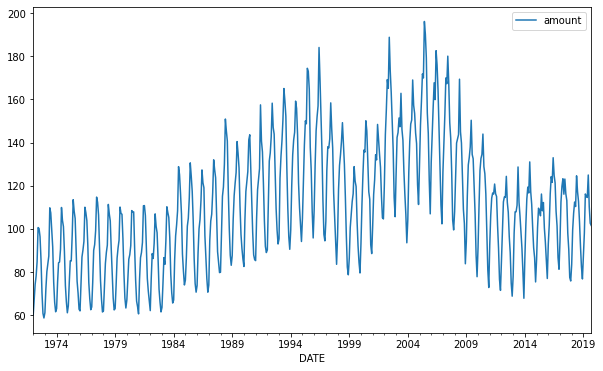

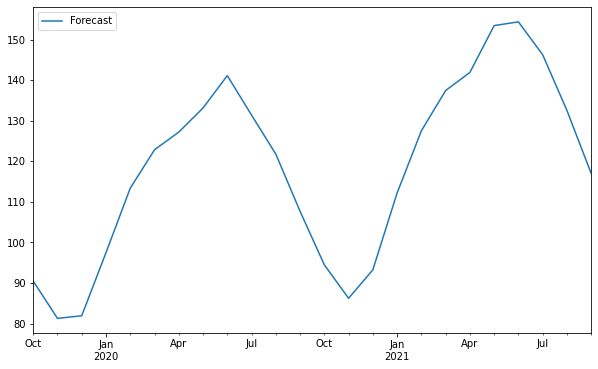

In [365]:
df.plot()
forecast_df.plot()

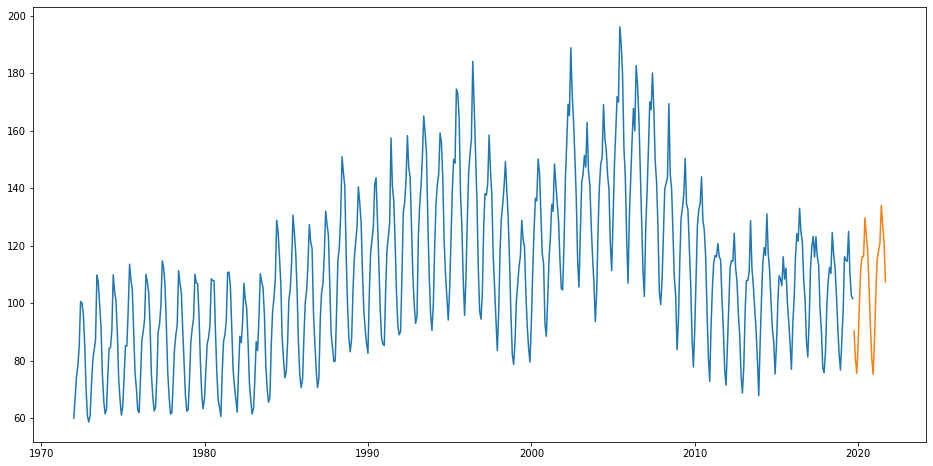

In [117]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

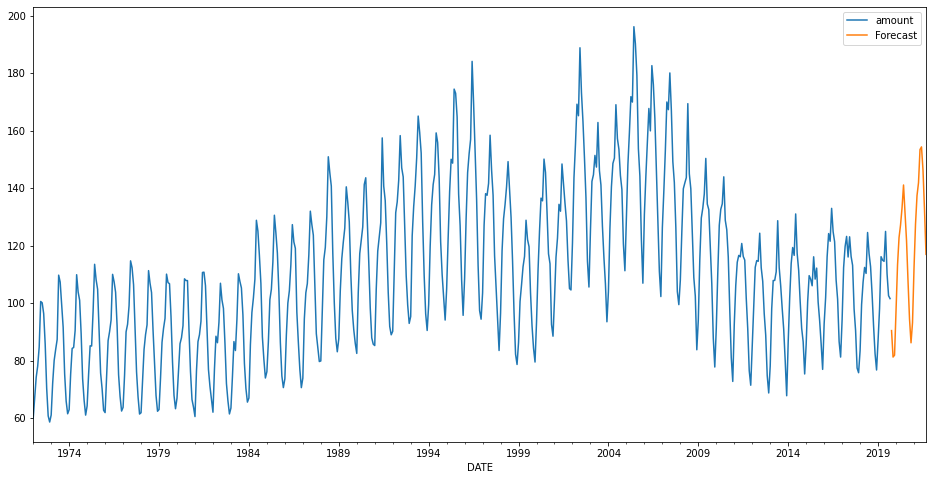

In [366]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(594.0, 598.0)

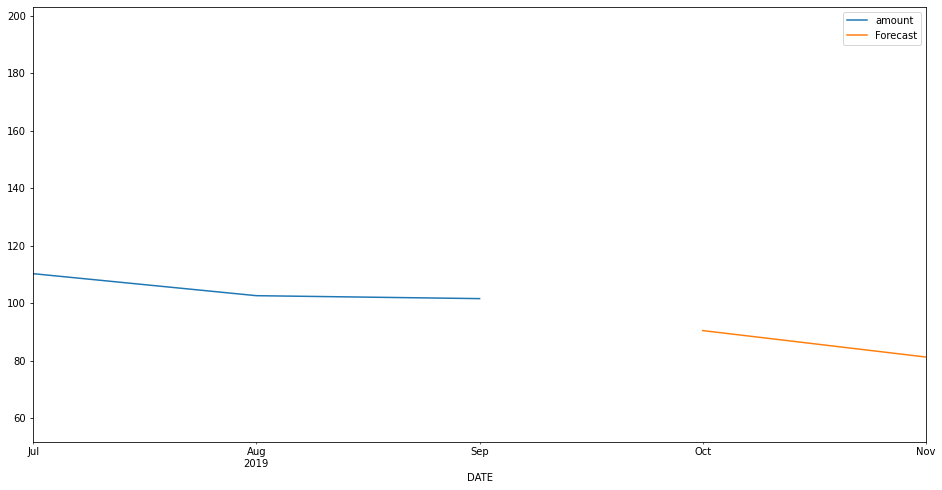

In [367]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2019-07-01', '2019-11-01')

# LAsT

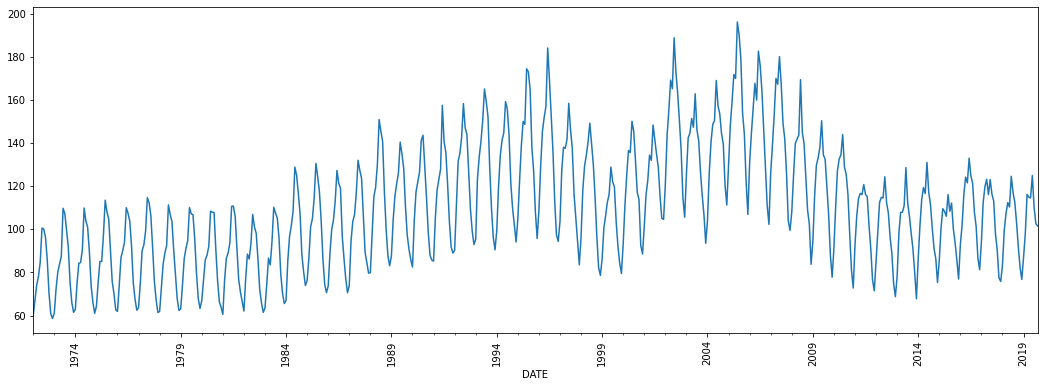

In [120]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

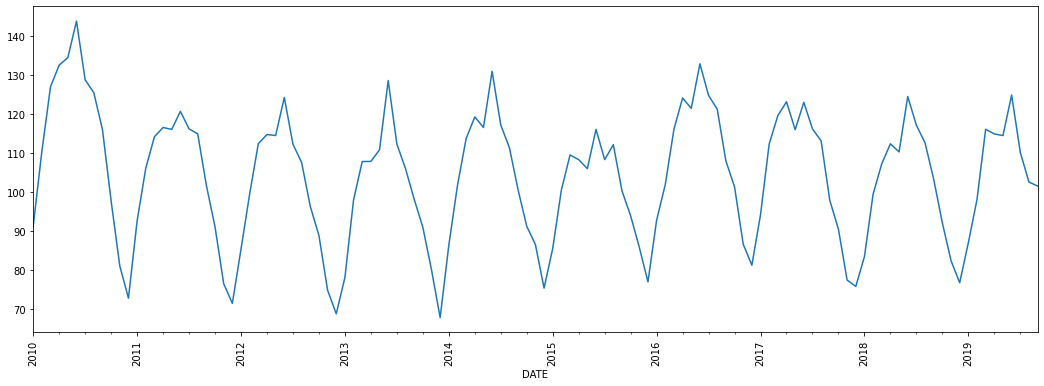

In [121]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [122]:
df = df.loc["2010-01-01" : "2019-09-01"]
df

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558
2010-06-01,143.952
2010-07-01,128.857
2010-08-01,125.556
2010-09-01,116.069


In [123]:
len(df)

117

### 5. Preprocessing of Data

### Train Test Split

In [203]:
len(df)

117

len(df) - 24

In [205]:
test_size = 24

In [206]:
test_ind = len(df)- test_size
test_ind

93

In [207]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [208]:
train

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558
2010-06-01,143.952
2010-07-01,128.857
2010-08-01,125.556
2010-09-01,116.069


In [209]:
test

,amount
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [210]:
from sklearn.preprocessing import StandardScaler

In [211]:
scaler = StandardScaler()

In [212]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [213]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [308]:
# help(TimeseriesGenerator)

In [214]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [215]:
generator[0]

(array([[[-0.81278024],
         [ 0.31932589],
         [ 1.297486  ],
         [ 1.6245491 ],
         [ 1.73715918],
         [ 2.29079791],
         [ 1.40117945],
         [ 1.20668131],
         [ 0.64753819],
         [-0.43192267],
         [-1.41404311],
         [-1.90360347]]]),
 array([[-0.73489965]]))

In [216]:
train_scaled

array([[-0.81278024],
       [ 0.31932589],
       [ 1.297486  ],
       [ 1.6245491 ],
       [ 1.73715918],
       [ 2.29079791],
       [ 1.40117945],
       [ 1.20668131],
       [ 0.64753819],
       [-0.43192267],
       [-1.41404311],
       [-1.90360347],
       [-0.73489965],
       [ 0.06392001],
       [ 0.54026748],
       [ 0.68023448],
       [ 0.65153978],
       [ 0.92482608],
       [ 0.65890646],
       [ 0.58474458],
       [-0.19594715],
       [-0.82386562],
       [-1.6837934 ],
       [-1.98143102],
       [-1.15994554],
       [-0.32528255],
       [ 0.43645028],
       [ 0.57342935],
       [ 0.55898476],
       [ 1.13516554],
       [ 0.42703271],
       [ 0.15098832],
       [-0.51336873],
       [-0.95440327],
       [-1.78235374],
       [-2.13998563],
       [-1.58905195],
       [-0.41529753],
       [ 0.16517361],
       [ 0.16671177],
       [ 0.34370078],
       [ 1.39141417],
       [ 0.4295197 ],
       [ 0.05737839],
       [-0.40603908],
       [-0

In [217]:
X_act, y_act= generator[0]

In [218]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.81278024  0.31932589  1.297486    1.6245491   1.73715918  2.29079791
  1.40117945  1.20668131  0.64753819 -0.43192267 -1.41404311 -1.90360347]
Predict this y: 
 [[-0.73489965]]


## Modelling & Model Performance

### Creating Model

### with "relu" activation function

In [219]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [220]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 60,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/60
81/81 [==============================] - 2s 9ms/step - loss: 0.5344 - val_loss: 0.1969
Epoch 2/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1841 - val_loss: 0.0571
Epoch 3/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1340 - val_loss: 0.0768
Epoch 4/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1429 - val_loss: 0.0825
Epoch 5/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1191 - val_loss: 0.0673
Epoch 6/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1176 - val_loss: 0.0654
Epoch 7/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1270 - val_loss: 0.0723
Epoch 8/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1213 - val_loss: 0.0674
Epoch 9/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1246 - val_loss: 0.0962
Epoch 10/60
81/81 [==============================] - 0s 5ms/step - loss: 0.1101 - val_loss: 0.1726
Epoch 11/60
81/81 [

<AxesSubplot:>

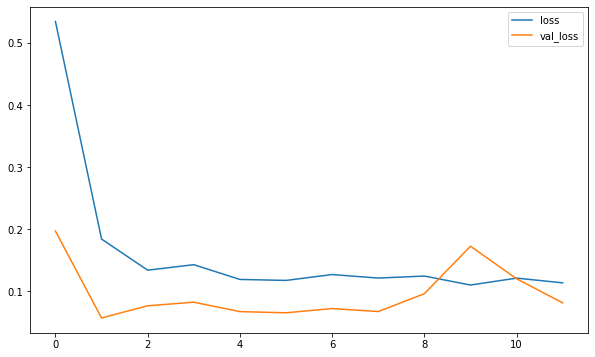

In [221]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.886567072123608 
 mae: 0.2188221888897727 
 mse: 0.0814110991777476 
 rmse: 0.2853263029896606


In [223]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

r2_score: 0.8152889786943998 
 mae: 0.3184210579568664 
 mse: 0.14198163752954154 
 rmse: 0.37680450837210205


#### Inverse Transformations and Comparing

In [224]:
true_predictions = scaler.inverse_transform(test_predictions)

In [225]:
test

,amount
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


In [226]:
test['predictions'] = true_predictions

In [322]:
test

,amount,predictions
DATE,,
2016-10-01,101.384,97.161
2016-11-01,86.665,84.793
2016-12-01,81.257,75.771
2017-01-01,94.245,87.843
2017-02-01,112.388,101.594
2017-03-01,119.698,110.658
2017-04-01,123.228,114.966
2017-05-01,116.064,117.508
2017-06-01,123.087,119.779


<AxesSubplot:xlabel='DATE'>

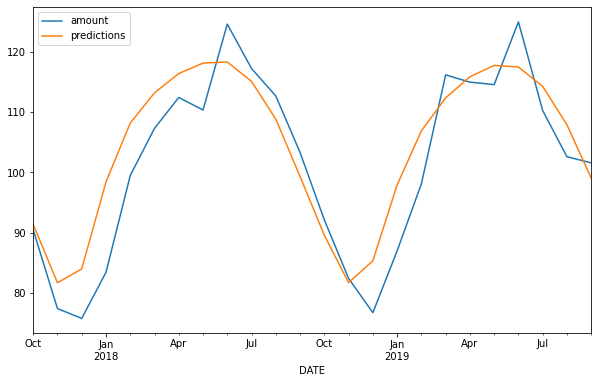

In [227]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [228]:
eval_metrics(test.amount, test.predictions)

r2_score: 0.815288984579568 
 mae: 5.403059402465821 
 mse: 40.87973674174511 
 rmse: 6.393726358059524
